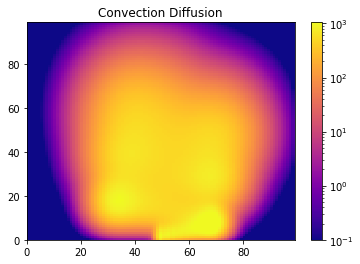

In [11]:
import numpy as np
import scipy as sp
import time, sys
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
mu=[0.2,0.001]
N=100
Ns=(N-1)**2
Nt=150
h=1./N
Tfinal = 3.
k=Tfinal/Nt
x1,x2=np.meshgrid(np.linspace(0,1,N+1)[1:-1],np.linspace(0,1,N+1)[1:-1],indexing='ij') # only free degrees of freedom
u0 = 0*x1#100*np.exp( -( ((x1-0.3)/0.125)**2 + ((x2-0.3)/0.125)**2) ) #IC of problem
u0 = u0.flatten()
x1=x1.flatten()
x2=x2.flatten()
t=np.linspace(0,Tfinal,Nt)


e=np.ones(N-1)
A1D_diff=1/h**2*sp.sparse.spdiags(np.vstack((e,-2*e,e)),[-1,0,1],N-1,N-1,format='csc') #twice differentiation
A2D_diff=sp.sparse.kron(A1D_diff,sp.sparse.eye(N-1,format='csc'),format='csc')+sp.sparse.kron(sp.sparse.eye(N-1,format='csc'),A1D_diff,format='csc')
A1D_conv=1/(h)*sp.sparse.spdiags(np.vstack((-1*e,1*e,0*e)),[-1,0,1],N-1,N-1,format='csc') 
A2D_conv=sp.sparse.kron(A1D_conv,sp.sparse.eye(N-1,format='csc'),format='csc') + \
         0.1*sp.sparse.kron(sp.sparse.eye(N-1,format='csc'),A1D_conv,format='csc')
I=sp.sparse.eye(Ns,format='csc')

A= -mu[0]*A2D_conv + mu[1]*A2D_diff

f=np.zeros((Ns,Nt+1))
for i in range(Nt):
    f[:,i] = 100000*np.exp( -( ((x2-0.5+(0.2*np.sin(2*np.pi*t[i])))/0.01)**2 + ((x1-0)/0.05)**2)    )

u=np.zeros((Ns,Nt+1))
# u0 = np.exp( -( ((x1-0.3)/0.125)**2 + ((x2-0.3)/0.125)**2) ) #IC of problem
# u0 = u0.flatten()
u[:,0] = u0
for n in range(Nt):
    # u[:,n+1]=spsolve(I-k*A,k*f[:,n+1])#+k*f[:,n+1])
    u[:,n+1]=spsolve(I-k*A,u[:,n]+k*f[:,n+1])#+k*f[:,n+1])
UstHF=u[:,1:].flatten(order='F')


# First set up the figure, the axis, and the plot element we want to animate
from matplotlib import animation, rc
from matplotlib.colors import LogNorm
from IPython.display import HTML
U_orig = np.reshape(UstHF,(Ns,Nt),order="F") #UstHF.reshape(Ns,Nt)
#U_ROM = np.reshape(UstROM,(Ns,Nt),order="F")
ti = 0
title = 'Convection Diffusion'
u_mx = np.max(np.abs(U_orig[:,0].reshape(N-1,N-1)))
u_min = 0.1
fig = plt.figure()
ax = fig.add_subplot(111)
plt.title(title)
cmap = plt.cm.plasma
img = ax.pcolormesh(U_orig[:,0].reshape(N-1,N-1), vmin=u_min, vmax=u_mx, norm=LogNorm(), cmap = cmap)
fig.colorbar(img, orientation='vertical')
#plt.show()

# initialization function: plot the background of each frame
def init():
    img = ax.pcolormesh(U_orig[:,0].reshape(N-1,N-1), vmin=u_min, vmax=u_mx, norm=LogNorm(), cmap = cmap)
    return (fig,)

# animation function. This is called sequentially
def animate(i):
    # u_mx = np.max(np.abs(U_orig[:,i].reshape(N-1,N-1)))
    img = ax.pcolormesh(U_orig[:,i].reshape(N-1,N-1), vmin=u_min, vmax=u_mx, norm=LogNorm(), cmap = cmap)
    return (fig,)

# call the animator. blit=True means only re-draw the parts that have changed.
plt.rcParams['animation.ffmpeg_path'] = '/opt/anaconda2/bin/ffmpeg'
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=Nt, interval=1, blit=True)

writer = animation.writers['ffmpeg'](fps=1)
HTML(anim.to_html5_video())
anim.save('conv_diff_Source.mp4', fps=20, extra_args=['-vcodec', 'libx264'])